## 1.4 Ideal Checkerboard and Zhang calibration w/ sensor measures
>In this part, it is intended to test ideal calibration and see how good is openCV calibration.


In order to do that, it was created chessboard using meshgrid in 3D and do 2D correspondence using DLT. After having the image correspondence, the axis is changed to the chessboard and it is created another axis where the Z coordinate is 0, since the reference coordinate frame starts from the chessboard. With that, it is implemented the method  *cv2.calibratecamera()* and it is obtained the **reprojection error**.\
In this script, the measures used are the approximate camera sensor ones.

**Import libraries**

In [2]:
#%matplotlib qt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from typing import Sequence
from camera_models import *  # our package

DECIMALS = 2  # how many decimal places to use in print

from utils import *

In [4]:
def to_inhomogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("x must be one-dimensional.")

    return (X / X[-1])[:-1]


def to_homogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("X must be one-dimensional.")

    return np.hstack([X, 1])

def to_homogeneous_arr(X: np.ndarray) -> np.ndarray:
    one_matrix = np.ones((X.shape[0],1))

    out_value = np.concatenate((X, one_matrix), axis=1)

    return out_value

def _get_roll_matrix(theta_x: float = 0.0) -> np.ndarray:
    Rx = np.array(
        [
            [1.0, 0.0, 0.0],
            [0.0, np.cos(theta_x), -np.sin(theta_x)],
            [0.0, np.sin(theta_x), np.cos(theta_x)],
        ]
    )
    return Rx


def _get_pitch_matrix(theta_y: float = 0.0) -> np.ndarray:
    Ry = np.array(
        [
            [np.cos(theta_y), 0.0, np.sin(theta_y)],
            [0.0, 1.0, 0.0],
            [-np.sin(theta_y), 0.0, np.cos(theta_y)],
        ]
    )
    return Ry


def _get_yaw_matrix(theta_z: float = 0.0) -> np.ndarray:
    Rz = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 0.0],
            [np.sin(theta_z), np.cos(theta_z), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )
    return Rz


#my and mx correspond to the pixel density in the x and y direction
def get_calibration_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = np.diag([mx, my, 1]) @ np.array([[f, 0.0, px], [0.0, f, py], [0.0, 0.0, 1.0]])
    return K

def get_rotation_matrix(
    theta_x: float = 0.0, theta_y: float = 0.0, theta_z: float = 0.0
) -> np.ndarray:
    # Roll
    Rx = _get_roll_matrix(theta_x)
    # Pitch
    Ry = _get_pitch_matrix(theta_y)
    # Yaw
    Rz = _get_yaw_matrix(theta_z)
    return Rz @ Ry @ Rx

def get_translation_matrix(Tx: float,Ty: float,Tz: float):
    return np.array([[Tx],[Ty],[Tz]])

def get_extrinsic_matrix(rot: np.array((3,3)), trans:np.array((3,1))):
    E = np.concatenate((rot,trans), axis = 1)
    return E

def get_projection_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    tx : float = 0.0,
    ty : float = 0.0,
    tz : float = 0.0,
    theta_x: float = 0.0,
    theta_y: float = 0.0,
    theta_z: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = get_calibration_matrix(f=f, px=px, py=py, mx=mx, my=my)
    #print("Calibration matrix: \n",K)
    R = get_rotation_matrix(theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    #print("Rotation matrix: \n",R)
    T = get_translation_matrix(tx,ty,tz)
    #print("Translation matrix: \n",T)
    E = get_extrinsic_matrix(rot = R,trans = T)
    P = K @ E
    
    return P

def get_plucker_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A = to_homogeneous(A)
    B = to_homogeneous(B)
    L = A.reshape(-1, 1) * B.reshape(1, -1) - B.reshape(-1, 1) * A.reshape(1, -1)
    return L



def normalization(data, dim):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Inputs:
    data: the data to be normalized (directions at different columns and points at rows) -> (nº points, nº coordinates)
    Outputs:
    T : the transformation matrix (translation plus scaling)
    '''

    N = data.shape[0]
    
    if dim == 2:                                                     # 2D points
        x, y = data[:, 0], data[:, 1]                               # x and y coordinates
        x_mean, y_mean = x.mean(), y.mean()                         # mean 
        x_par = (x-x_mean)**2                                       # x part
        y_par = (y-y_mean)**2                                       # y part

        d = (1/N)* np.sum(np.sqrt(x_par + y_par))                   # d
        s_xy = np.sqrt(2)/d                                         # sqrt(2)/d

        T = np.zeros((3,3))                                         # normalization matrix for 2D points
        T[0,0] = s_xy
        T[0,2] = -x_mean*s_xy
        T[1,1] = s_xy
        T[1,2] = -y_mean*s_xy
        T[-1,-1] = 1

        coord_n = np.dot(data,np.transpose(T))                          # normalized image coordinates

    elif(dim== 3):                                                  # 3D points
        X, Y, Z = data[:, 0], data[:, 1], data[:,2]                 # x and y coordinates
        X_mean, Y_mean,Z_mean = X.mean(), Y.mean(),Z.mean()         # mean 
        X_par = (X-X_mean)**2                                       # x part
        Y_par = (Y-Y_mean)**2                                       # y part
        Z_par = (Z-Z_mean)**2                                       # z part

        D = (1/N)* np.sum(np.sqrt(X_par + Y_par + Z_par))           # d
        s_xyz = np.sqrt(3)/D                                        # sqrt(2)/d

        T = np.zeros((4,4))                                         # normalization matrix for 3D points
        T[0,0] = s_xyz
        T[0,3] = -X_mean*s_xyz
        T[1,1] = s_xyz
        T[1,3] = -Y_mean*s_xyz
        T[2,2] = s_xyz
        T[2,3] = -Z_mean*s_xyz
        T[-1,-1] = 1

        coord_n = np.dot(data,T.T)                          # normalized world coordinates

    else:
        raise ValueError('Dataset must be a collection of 2D or points')

    return T,coord_n

def denormalization(H_norm,Txy,Txyz):
    H = np.linalg.pinv(Txy).dot((H_norm).dot(Txyz))
    H = H / H[-1, -2]

    return H


def create_chessboard(patternsize_x,patternsize_y):
    """
    Creates chessboard with pattern dimensions
    patternsize_x[in] - size x of the chessboard
    patternsize_y[in] - size y of the chessboard
    world_pts_arr[out] - meshgrid points
    """
    pattern_size_x,pattern_size_y = (patternsize_x,patternsize_y)

    X = np.linspace(-pattern_size_x/2, pattern_size_x/2,pattern_size_x + 1)
    Y = np.linspace(-pattern_size_y/2, pattern_size_y/2,pattern_size_y + 1)

    zdata = np.zeros((patternsize_x + 1,patternsize_y + 1))
    xdata, ydata = np.meshgrid(X, Y)

    xdata_ = xdata.flatten()
    ydata_ = ydata.flatten()
    zdata_ = zdata.flatten()
    onedata = np.ones((zdata_.shape[0])).flatten()
    # homogeneous coordinates
    world_pts =([xdata_,ydata_,zdata_,onedata])
    world_pts_arr = np.array(world_pts).T

    return world_pts_arr

def get_chessboard_rot_trans(world_pts_arr,rx, ry, rz, tx,ty,tz):
    """
    rotates and translates the chessboard
    world_pts_arr[in] - chessboard points in homogenous coordinates[4,1]
    rx[in] - rotation on the x axis
    ry[in] - rotation on the y axis
    rz[in] - rotation on the z axis
    tx[in] - translation on the x axis
    ty[in] - translation on the y axis
    tz[in] - translation on the z axis
    world_trans_arr[out] - output chessboard rotation and translation 
    """ 
    
    Rx =get_rotation_matrix(rx,ry,rz)
    Trans = np.array([[tx],[ty],[tz]])
    E = np.concatenate((Rx,Trans),axis=1)

    world_trans_arr = np.dot(world_pts_arr,E.T)

    return world_trans_arr

### Intrisic and extrinsic parameters

In [6]:
F = 16                                       # focal length( in mm )
sensor_size = np.array([11,7])              # sensor size(mm)
PX= sensor_size[0]/2.0                      # principal point x-coordinate
PY= sensor_size[1]/2.0                      # principal point y-coordinate
IMAGE_HEIGTH = sensor_size[1]
IMAGE_WIDTH = sensor_size[0]
THETA_X = -np.pi / 2                         # roll angle
THETA_Z = np.pi/2                             # yaw angle

C = np.array([8,2,4])                    # camera centre


In [27]:
def get_image_points(rand_points,px,py,thetax = 0, thetay = 0, thetaz = 0,trans_x = 0,trans_y = 0,trans_z = 0,F = F):

    K = get_calibration_matrix(F, px=px, py=py)                                             # calibration matrix
    #print(K)
    P = get_projection_matrix(F, px=px,py =py,theta_x = thetax,theta_y = thetay,theta_z = thetaz,tx = trans_x,ty = trans_y, tz = trans_z)                        # projection matrix
    #print("\nCalibration matrix (K):\n", K)
    #print("\nProjection matrix (P):\n", P)

    x = []

    for i in range(rand_points.shape[1]):
        Xh = to_homogeneous(rand_points[:,i])
        xh = P @ Xh
        Xx = to_inhomogeneous(xh)
        x.append(Xx)

    x_arr = np.array(x)

    return x_arr, rand_points.T

In [8]:
def SVD(M):
    U, S, Vh = np.linalg.svd(M)

    L = Vh[-1,:] / Vh[-1,-2]
    #Camera projection matrix:
    PEst = L.reshape(3,3+1)
    #print("Camera Matrix:\n",PEst)

    return PEst

In [9]:
def DLT(x_arr,X_arr):

    worldm, worldn = X_arr.shape
    imagem, imagen = x_arr.shape
    
    #3D DLT
    A = []
    world_pts = X_arr
    image_pts = x_arr

    for i in range(worldm):
        A.append([-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,0,0,0,0,image_pts[i,0]*world_pts[i,0],image_pts[i,0]*world_pts[i,1],image_pts[i,0]*world_pts[i,2],image_pts[i,0]])
        A.append([0,0,0,0,-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,image_pts[i,1]*world_pts[i,0],image_pts[i,1]*world_pts[i,1],image_pts[i,1]*world_pts[i,2],image_pts[i,1]])

    # pass the list A as an array
    M = np.asarray(A).reshape(worldm*2,12)
    #print(M.shape)
    
    PEst = SVD(M)
    return PEst

In [10]:

def get_plane(X,dimx,dimy):
    """
    X[in] : array with the coordinate set
    dimx[in] : dimension of the chessboard along the x axis
    dimy[in] : dimension of the chessboard along the y axis
    x_surface[out] : surface plane x
    y_surface[out] : surface plane y
    z_surface[out] : surface plane z
    """
    x_plane, y_plane, z_plane = X[:,0],X[:,1],X[:,2]
    x_surface = np.array( [ [x_plane[0],x_plane[dimx]] ,[x_plane[dimx+1],x_plane[((dimx+1)*2) - 1]] ,[x_plane[(dimx+1)*2],x_plane[((dimx+1)*3) - 1]] ,[x_plane[(dimx+1)*3],x_plane[((dimx+1)*4) - 1]],[x_plane[(dimx+1)*4],x_plane[((dimx+1)*5) - 1]]])
    y_surface = np.array( [ [y_plane[0],y_plane[dimx]] ,[y_plane[dimx+1],y_plane[((dimx+1)*2) - 1]] ,[y_plane[(dimx+1)*2],y_plane[((dimx+1)*3) - 1]] ,[y_plane[(dimx+1)*3],y_plane[((dimx+1)*4) - 1]],[y_plane[(dimx+1)*4],y_plane[((dimx+1)*5) - 1]]])
    z_surface = np.array( [ [z_plane[0],z_plane[dimx]] ,[z_plane[dimx+1],z_plane[((dimx+1)*2) - 1]] ,[z_plane[(dimx+1)*2],z_plane[((dimx+1)*3) - 1]] ,[z_plane[(dimx+1)*3],z_plane[((dimx+1)*4) - 1]],[z_plane[(dimx+1)*4],z_plane[((dimx+1)*5) - 1]]])

    return x_surface, y_surface,z_surface

### 3D to 2D correspondance for one chessboard

In [13]:
world_pts = create_chessboard(4,4)
X = get_chessboard_rot_trans(world_pts,np.pi/2,0,np.pi/2,-1*20,2,4)

In [14]:
x_arr, X_arr = get_image_points(X.T,PX,PY,-np.pi/2,np.pi/2,trans_x= C[0],trans_y= C[1],trans_z= C[2],F = F)

X_h = to_homogeneous_arr(X_arr)
x_h = to_homogeneous_arr(x_arr)


P_n = DLT(x_h,X_h)

print("Camera Matrix:\n",P_n)

n_points = X_h.shape[0]
xEst = np.zeros((n_points,2))

for j in range(n_points):
    X_pts = to_homogeneous(X_arr[j])
    x_aux  = np.dot(P_n,X_pts)
    xEst[j,:] = to_inhomogeneous(x_aux)
    
err_list = np.sqrt(np.mean(np.sum(np.square(x_arr-xEst), 1)))

print("Geometric error:",err_list)

[[16.   0.   5.5]
 [ 0.  16.   3.5]
 [ 0.   0.   1. ]]
Camera Matrix:
 [[ 3.83803610e+13  3.63591239e+14 -2.01282051e+00 -5.14075041e+15]
 [-1.21536644e+14  3.47756410e-01 -3.63591239e+14 -5.06676936e+15]
 [-4.75213000e+13  7.24358974e-01  1.00000000e+00 -1.49581286e+15]]
Geometric error: 6.278359794730111e-14


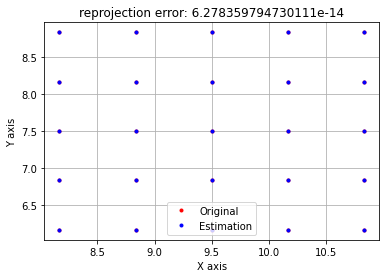

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_arr[:,0],x_arr[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("reprojection error: " + str(err_list))
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(xEst[:,0],xEst[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

In [16]:
R = get_rotation_matrix(theta_x=THETA_X, theta_z=THETA_Z)
world_origin = np.zeros(3)
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frame = ReferenceFrame(
    origin=C, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Image",
)
image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

In [17]:
G = []
L = []
pi = []
x = []
#X = np.array([[6, 2,5],[6,4,5]])                        # Create a random point
for i in range(X.shape[0]):
    G.append(GenericPoint(X[i], name="X"))                   
    L.append(get_plucker_matrix(C, X[i]))
    X1 = image_frame.origin
    X2 = X1 + image_frame.dx
    X3 = X1 + image_frame.dy
    pi.append(get_plane_from_three_points(X1, X2, X3))
    x.append(to_inhomogeneous(L[i] @ pi[i]))

    """
    print(f"X:\n{X}")
    print(f"\nL:\n{L[i].round(DECIMALS)}")
    print(f"\nX1:\n{X1}")
    print(f"\nX2:\n{X2}")
    print(f"\nX3:\n{X3}")
    print(f"\npi:\n{pi[i].round(DECIMALS)}")
    print(f"\nx:\n{x[i].round(DECIMALS)}")
    """
x_arr = np.array(x)

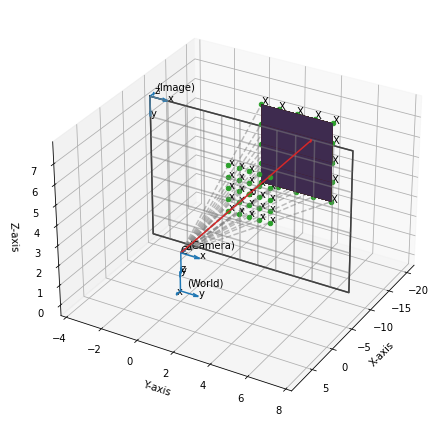

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.text(*C, "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
for i in range(len(G)):
    G[i].draw3d(pi[i], C=C)
    x_surface, y_surface, z_surface = get_plane(X,4,4)
    ax.plot_surface(x_surface,y_surface,z_surface)

ax.view_init(elev=30.0, azim=30.0)

#ax.set_title(f"Representation of a Generic Point in 3D (X = {X})")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.tight_layout()
plt.show()

In [21]:
translst= []
x_range = ([-30,-20])
y_range = np.linspace(-30,30,31)
z_range = np.linspace(-30,10,21)
for x in x_range:
    for z in range(-10,10,2):
        for y in range(-30,30,5):
            translst.append([x,y,z])

#translst

In [22]:
# chessboard print
chess_pts = []
world_pts = create_chessboard(4,4)
rotangles = [[np.pi/2,0,np.pi/2],[-np.pi/3,0,np.pi/2],[np.pi/3,0,np.pi/2],[np.pi/2,0,np.pi/3],[np.pi/2,0,-np.pi/3]]
transangles =  [[1,6,2],[1,4,2],[1,2,2],[1,0,2],[1,-2,2],[1,6,4],[1,4,4],[1,2,4],[1,0,4],[1,-2,4],[1,6,6],[1,4,6],[1,2,6],[1,0,6],[1,-2,6]]

for i in range(len(translst)):
    for j in range(len(rotangles)):    
        chess_pts.append(get_chessboard_rot_trans(world_pts,rotangles[j][0],rotangles[j][1],rotangles[j][2],translst[i][0],translst[i][1],translst[i][2]))

chess_pts_arr = np.array(chess_pts)
chess_pts_arr.shape

(1200, 25, 3)

In [23]:
R = get_rotation_matrix(theta_x=THETA_X, theta_z=THETA_Z)
world_origin = np.zeros(3)
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frame = ReferenceFrame(
    origin=C, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Image",
)
image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

In [24]:
planes_lst = []
for i in range(chess_pts_arr.shape[0]):
    planes_lst.append(get_plane(chess_pts_arr[i,:,:],4,4))

planes_arr = np.array(planes_lst)

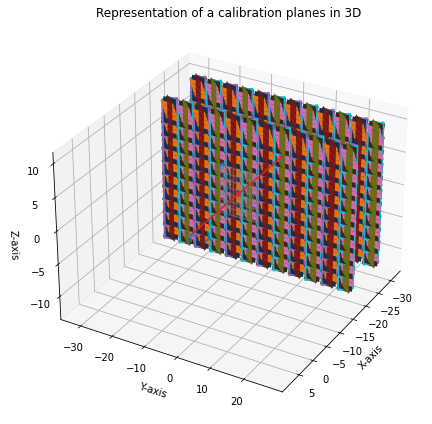

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.text(*C, "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
for i in range(chess_pts_arr.shape[0]):
    x_surface, y_surface, z_surface = get_plane(chess_pts_arr[i,:,:],4,4)
    ax.plot_surface(x_surface,y_surface,z_surface)

ax.view_init(elev=30.0, azim=30.0)

ax.set_title(f"Representation of a calibration planes in 3D")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.tight_layout()
plt.show()

### Get the homographies of the different chessboards

In [28]:
x_lst = []
for i in range(chess_pts_arr.shape[0]):
    x_arr, X_arr = get_image_points(chess_pts_arr[i,:,:].T,PX,PY,-np.pi/2,np.pi/2,trans_x= C[0],trans_y= C[1],trans_z= C[2],F = F)

    x_lst.append(x_arr)

x_zhang = np.array(x_lst,np.float32)

### Get the world coordinates for the chessboard
>Coordinate set with Z = 0

In [29]:
patternsize_x = 4
patternsize_y = 4

pattern_size_x,pattern_size_y = (patternsize_x,patternsize_y)

X = np.linspace(0, pattern_size_x,pattern_size_x + 1)
Y = np.linspace(0, pattern_size_y,pattern_size_y + 1)

zdata = np.zeros((patternsize_x + 1,patternsize_y + 1))
xdata, ydata = np.meshgrid(X, Y)

xdata_ = xdata.flatten()
ydata_ = ydata.flatten()
zdata_ = zdata.flatten()
# homogeneous coordinates
world_pts =([xdata_,ydata_,zdata_])
world_pts_ = np.array(world_pts).T

world_pts_arr = np.zeros((chess_pts_arr.shape[0],25,3),np.float32)
for i in range(chess_pts_arr.shape[0]):
    world_pts_arr[i,:,:] = world_pts_

world_pts_arr = world_pts_arr.reshape(world_pts_arr.shape[0],1,25,3)
world_pts_arr.shape

(1200, 1, 25, 3)

## OpenCV calibration method

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(world_pts_arr, x_zhang, (11,7), None, None)

In [ ]:
print("Intrisic Camera Matrix:\n" + str(mtx))
#print("Lens distortion coefficients:\n" + str(dist))
#print("Rotation vetors\n" + str(rvecs))
#print("Translation vetors\n" + str(tvecs))
print("Error\n" + str(ret))


In [ ]:
for i in range(len(world_pts_arr)):
    imgpoints2, _ = cv2.projectPoints(world_pts_arr[i], rvecs[0], tvecs[0], mtx, dist)
    imgpoints2 = imgpoints2.reshape(-1,2)

In [ ]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot()
ax.scatter(imgpoints2[:,0],imgpoints2[:,1], label = "reprojected points")
ax.scatter(x_zhang[0,:,0],x_zhang[0,:,1], label = "original points")
#ax.set_xlim([0,sensor_size[0]])
#ax.set_ylim([0,sensor_size[1]])
ax.grid()
ax.legend()
ax.set_title("reprojected and original points")
plt.show()